In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("E:\Machine Learning\Competitions - Kaggle\House Prices Advanced Regression Techniques/train.csv")
test = pd.read_csv("E:\Machine Learning\Competitions - Kaggle\House Prices Advanced Regression Techniques/test.csv")

In [3]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [4]:
all_data = pd.get_dummies(all_data)

In [5]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [6]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [7]:
from __future__ import print_function
import tensorflow as tf

In [8]:
y=y.reshape(1460,1)

C:\Users\manish_jain04.ITLINFOSYS\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [9]:
print('Training set', X_train.shape, y.shape)
print('Test set',X_test.shape)

Training set (1460, 288) (1460, 1)
Test set (1459, 288)


In [10]:
X_train=X_train.T
X_test=X_test.T


In [11]:
y=y.T

In [12]:
print('Training set', X_train.shape, y.shape)
print('Test set',X_test.shape)

Training set (288, 1460) (1, 1460)
Test set (288, 1459)


In [13]:
X_train=X_train.astype(np.float32)
X_test=X_test.astype(np.float32)
y =y.astype(np.float32)


In [14]:
print('Training set', X_train.shape, y.shape)
print('Test set',X_test.shape)

Training set (288, 1460) (1, 1460)
Test set (288, 1459)


In [15]:
def reformat(dataset, labels):
  
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(1) == labels[:,:]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(X_train, y)
                                     
print('Training set', train_dataset.shape, train_labels.shape)


Training set (288, 1460) (1, 1460)


In [16]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

In [17]:

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32,shape=(n_x,None))
    Y = tf.placeholder(tf.float32,shape=(n_y,None))
    
    return X, Y

In [18]:
X, Y = create_placeholders(12288, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(6, ?), dtype=float32)


In [19]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [1, 12]
                        b3 : [1, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [25,288], initializer = tf.contrib.layers.xavier_initializer(seed = 1),dtype=tf.float32)
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer(),dtype=tf.float32)
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1),dtype=tf.float32)
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer(),dtype=tf.float32)
    W3 = tf.get_variable("W3", [1,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1),dtype=tf.float32)
    b3 = tf.get_variable("b3", [1,1], initializer = tf.zeros_initializer(),dtype=tf.float32)
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [20]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    A3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                          # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                              # Z3 = np.dot(W3,Z2) + b3
    A3 = tf.nn.relu(Z3)
    ### END CODE HERE ###
    
    return A3

In [21]:
def compute_cost(A3, Y):
    """
    Computes the cost
    
    Arguments:
    A3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    #logits = tf.transpose(A3)
    #labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.square(tf.squeeze(A3)-tf.squeeze(Y)))
                  
    
    ### END CODE HERE ###
    
    return cost

In [22]:
def model(X_train, Y_train, learning_rate = 0.0001,
          num_epochs = 501, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    A3 = forward_propagation(X,parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(A3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            #epoch_cost = 0.                       # Defines a cost related to an epoch
            #num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            #seed = seed + 1
            #minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            #for minibatch in minibatches:

                # Select a minibatch
             #   (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
            _ , epoch_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
                ### END CODE HERE ###
                
            #epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(A3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        #print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 454.743652
Cost after epoch 100: 0.036959
Cost after epoch 200: 0.005057
Cost after epoch 300: 0.000816
Cost after epoch 400: 0.000085
Cost after epoch 500: 0.000006


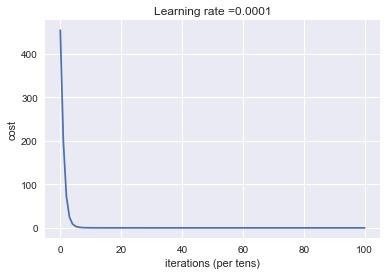

Parameters have been trained!
Train Accuracy: 1.0


In [23]:
parameters = model(train_dataset, train_labels)